In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn import metrics
from tqdm import tqdm
from pathlib import Path
import matplotlib.gridspec as gridspec
import matplotlib.colors as plt_colors
import matplotlib as mpl
import copy
import shap
from matplotlib.cm import ScalarMappable

from sklearn.preprocessing import LabelEncoder

import pickle

from IPython.display import display
from ipywidgets import interact_manual
import ipywidgets as widgets


In [2]:
# enable interactivity for shap force plots
shap.initjs()

In [3]:
def load_model(tin):
    ''' load pretrained model from ./data/
    
    params:
    tin: time interval (aka extincion)
         of model to load (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
         
    returns:
    model: pretrained model of the tin
           extinction
    '''
    model = CatBoostClassifier()
    model.load_model(f"../results/models/CGB_TimeInterval{tin}_Split1")
    return model

In [4]:
def load_data(tin):
    ''' load training dataset used for
    the trained model from ./data/
    
    params:
    tin: time interval (aka extincion)
         of model to load (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
         
    returns:
    data: dataset used to train model of 
          the tin extinction.
    '''
#     data = np.load(f'../data/TimeInterval{tin}.csv', allow_pickle=True)
    data = pd.read_csv(f'../data/TimeInterval{tin}.csv', index_col=0, sep=",")
    return data

In [5]:
def rename_cols(x_train_df):
    ''' reassign dataframe columns their
    correct names (for plotting reasons)
    
    params:
    x_train_df: dataframe of training 
                dataset.
    
    returns:
    x_train_df: same dataframe with up-
                dated column names.
    '''
    x_train_df.rename(columns={'NoSpeciesLN':'num of species',
                               'K_Numeric':'K',
                               'Min_Numeric':'Mineralogy',
                               'S_Numeric':'S',
                               'C_Numeric':'Carbonate load',
                               'O_Numeric':'Ornamentation',
                               'T_Numeric':'Tiering',
                               'M_Numeric':'Motility',
                               'R_Numeric':'Respiratory protein',
                               'Re_Numeric':'Reproduciton',
                               'Phylum_Numeric':'Phylum',
                               'MinD_Numeric':'Habitat depth'},
                     inplace=True)
    return x_train_df

In [6]:
def df_preprocessing(TIN):
        
    # initial reading
    data = pd.read_csv(f"../data/TimeInterval{TIN}.csv", index_col=0)

    # move species from index to the table
    data["species"] = data.index
    
    # create numeric idex
    data.index = range(len(data))
    
    # create categorical feature from Phylum (string)
    data["Phylum_Numeric"] = LabelEncoder().fit_transform(data["Phylum"].tolist()) + 1
    
    # remove features we will not use
    data = data.drop(["Phylum", "species", "occurrences", "NoSpecies", 
                      "C_Cnumeric", "SC_Numeric", "MaxD_Numeric", "System_Numeric"], axis=1)
    
    # create features and target dataframes
    features = data.drop(["extinct"], axis=1)
    target = data["extinct"]
    
    # create lists with categorical and continious features' names
    continious_cols = []
    categorical_cols = features.columns.drop(continious_cols).tolist()
    
    # make list of indexes
    categorical_idx = [features.columns.tolist().index(col) for col in categorical_cols]
        
    #return features, target, categorical_idx
    return features

In [7]:
def get_explainer(model, x_train):
    ''' generate tree explainer and calculate
    shap values for the trained model.
    
    params:
    model: loaded, pre-trained, tree-based ML model.
    x_train: dataset used to train this model.
         
    returns:
    explainer: 
    shap_values: Shapley values for quantifying the 
                 importance of each variable/feature
                 to the model prediction
    '''
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_train)
    return explainer, shap_values

In [8]:
# create color vision impairment friendly-colormap
def get_colormap(number_categories):
    ''' create color vision impairment friendly
    categorical colormap. Comes with 14 different
    colors.
    
    params:
    numer_categories: number of different cate-
                      gories needed (max=14).
    
    returns:
    cm: matplotlib colormap element.
    '''
    hex_list = ['#88CCEE', '#882255', '#999933', '#332288', '#DDCC77', '#117733', '#CC6677',
                '#44AA99', '#AA4499', '#DDDDDD', '#C70039', '#000000', '#D55E00', '#0072B2']
    rgb_list = []
    print(number_categories)
    for i in hex_list[:number_categories]:
        rgb_list.append(plt_colors.to_rgb(i))
    
    cmap = mpl.colors.ListedColormap(rgb_list)
    cpal = sns.set_palette(sns.color_palette(hex_list))
    return cmap, cpal

In [9]:
def prepare_shap(tin):
    ''' prepare all elements for shap
    plotting.
    
    params:
    tin: time interval (aka extincion)
         of interest (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
         
    returns:
    shap_values: Matrix of Shapley values.
    x_train_df: dataframe used for model 
                 training.
    curr_max: number of different categories of 
              most diverse feature.
    explainer:
    '''
    model = load_model(tin)
    x_train_df = df_preprocessing(tin)
    explainer, shap_values = get_explainer(model, x_train_df)
    curr_max = 0
    for col in x_train_df:
        if np.max(len(x_train_df[col].unique())) > curr_max:
            curr_max = np.max(len(x_train_df[col].unique()))
    return shap_values, x_train_df, curr_max, explainer

In [17]:
def shap_summary_dots(tin):
    ''' plot shap summary as beeswarm plot.
    This is a manual approach to shap.shap_summary
    from the original shap library.
    
    params:
    tin: time interval (aka extincion)
         of interest (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
    '''
    # prepare dataframes for correct coloring (wide to long df conversion)
    shap_values, x_train_df, max_cats, explainer = prepare_shap(tin)
    x_train_df = rename_cols(x_train_df)
    x_train_df_long = x_train_df.melt()
    shap_values_long = pd.DataFrame(shap_values).melt()
    x_train_df_long['shap'] = shap_values_long['value']
    cmap, cpal = get_colormap(max_cats)
    
    # get feature importance for ordering
    feature_importance = pd.DataFrame(list(zip(x_train_df.columns, sum(abs(shap_values)))),
                                      columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

    # do the plotting
    fig = plt.figure(dpi=180)
    fig.set_size_inches(7,3)
    ax = sns.stripplot(y=x_train_df_long['variable'], x=x_train_df_long['shap'], hue=x_train_df_long['value'],
                      order=np.array(feature_importance['col_name']), size=2, jitter=0.25,
                      palette=cpal)
    
    # remove frame and add some lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none') 
    plt.xlabel('SHAP value')
    plt.ylabel(tin, fontweight='bold')
    
    plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    print(x_train_df_long['value'].max())
    norm = plt.Normalize(0, max_cats)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cb = ax.figure.colorbar(sm)
    cb.outline.set_visible(False)
    cb.set_ticks([])
    
    #legend
    print(f'max_cats: {max_cats}')
    cb.ax.get_yaxis().set_ticks([])
    for j in range(1, max_cats+1):
        cb.ax.text(x_train_df_long['value'].max(), (j - 0.75), j)
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel('category (cf. Table 1)', rotation=90, labelpad=25)
    
    # finally show the plot
    fig.tight_layout()
    fig.savefig(f"../results/figures/shap_summary_plot_{tin}")
    plt.show()

13
13
max_cats: 13


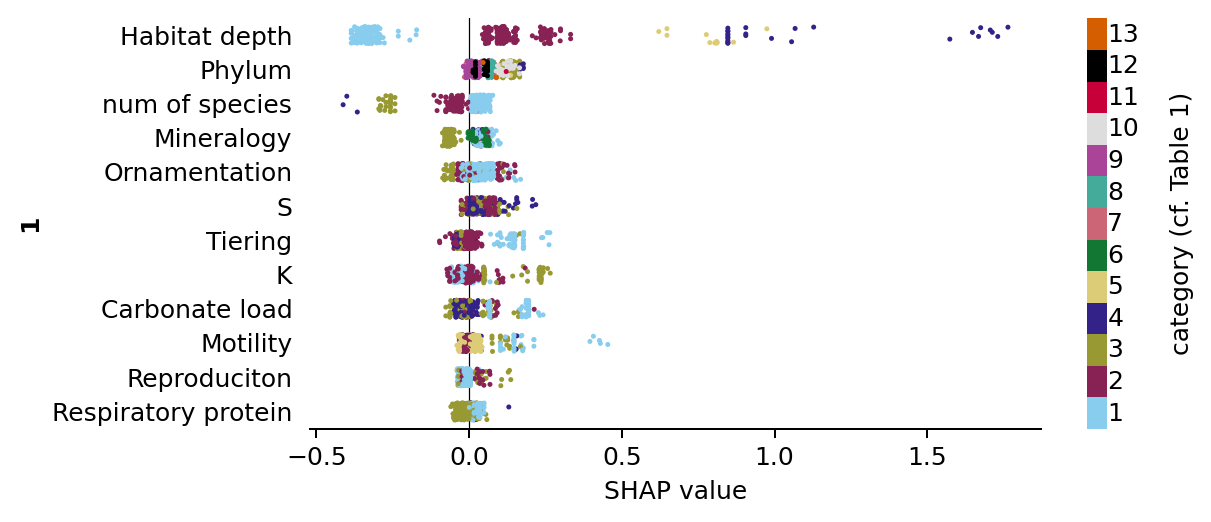

13
13
max_cats: 13


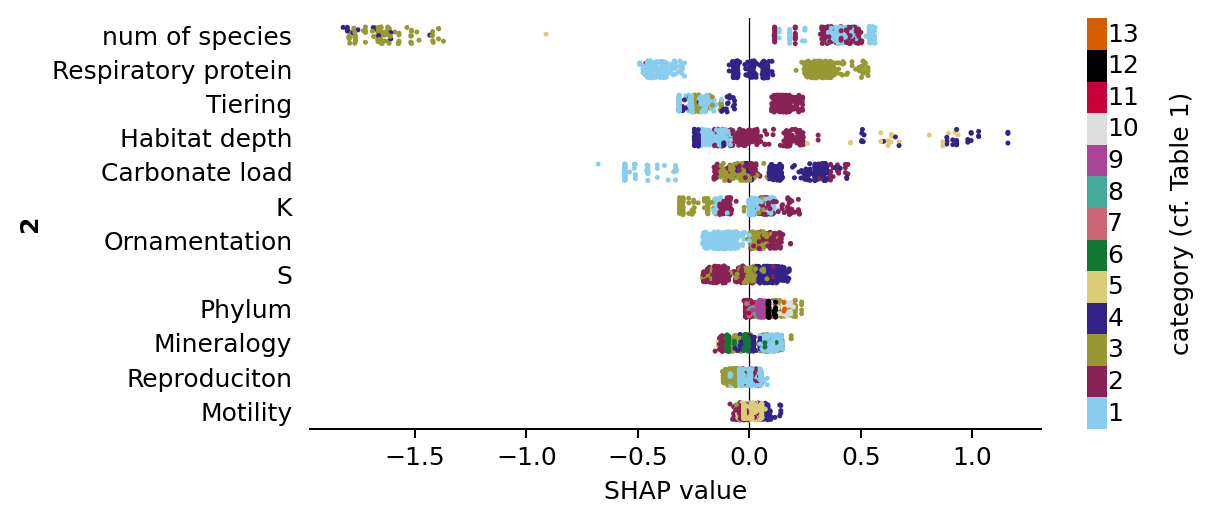

14
14
max_cats: 14


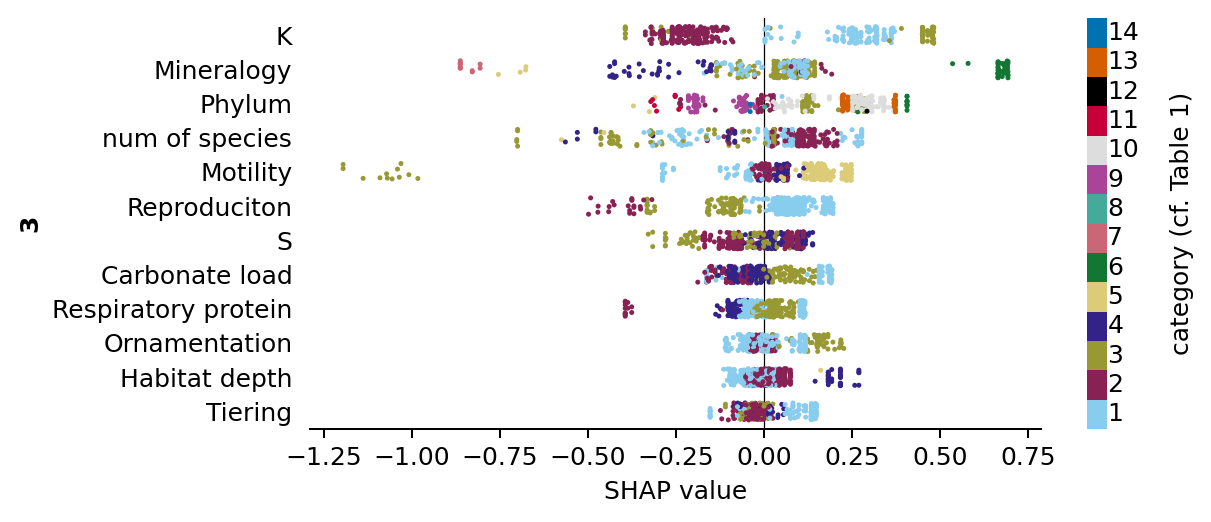

10
10
max_cats: 10


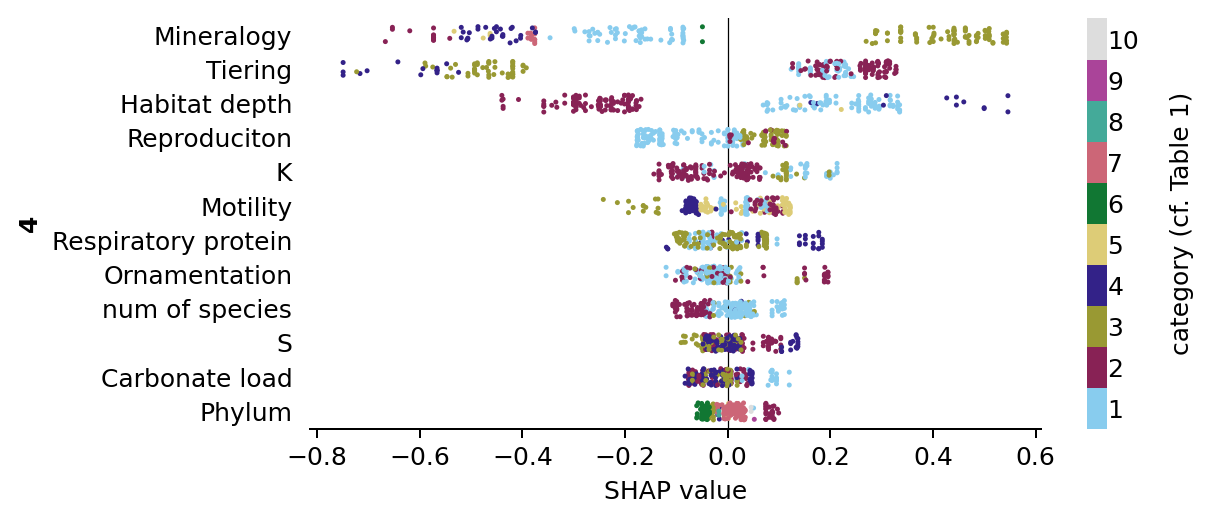

In [18]:
shap_summary_dots(1)
shap_summary_dots(2)
shap_summary_dots(3)
shap_summary_dots(4)

## Explaining individual predictions

In [46]:
def make_force_plot(tin, s_ind):
    ''' make force plots for specific samples.
    
    params:
    tin: time interval (aka extincion)
         of interest (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
    s_ind: index of sample to plot in dataset.
    '''
    shap_values, x_train_df, curr_max, explainer = prepare_shap(tin)
    x_train_df = rename_cols(x_train_df)
    display(shap.force_plot(explainer.expected_value,
                            shap_values[s_ind, :],
                            x_train_df.iloc[s_ind, :],
                            link='logit',
                            out_names="Extinction Probability",
                            plot_cmap=["#75485e", "#51a3a3"],
                            show=False))

In [48]:
make_force_plot(1, 413)

## Widget for interactive investigation

In [52]:
interact_manual(explain_single_prediction,
                prediction_index=widgets.IntSlider(min=0, max=500, step=1, value=0),
                model_name=widgets.Dropdown(options=["CGB", "RFC"], value="CGB"),
                TIN=widgets.IntSlider(min=1, max=4, step=1, value=1),
                split=widgets.IntSlider(min=1, max=5, step=1, value=1))

interactive(children=(IntSlider(value=0, description='prediction_index', max=500), Dropdown(description='model…

<function __main__.explain_single_prediction(prediction_index, model_name, TIN, split)>